# Are graph embeddings continuous? (Embedding by random walk matrix factorization)

Random walk factorization consists of representing a graph in a low dimensional space made of the principal eigenvectors of the transition matrix of a random walk defined it.

Let $A$ be the (weighted) adjacency matrix and $\epsilon \mapsto A(\epsilon)$ a continuous perturbation of $A$ (such as adding a small noise to the edges weights). [Acker](https://www.ams.org/journals/proc/1974-042-01/S0002-9939-1974-0326457-7/S0002-9939-1974-0326457-7.pdf) showed that the eigenvectors of $A(\epsilon)$ are continuous with respect to $\epsilon$ if its eigenvalues are all distinct at each $\epsilon$.

In the context of graph, multiplicity of adjacency eigenvalues usually occur only for the unit eigenvalue, and this multiplicity encodes the number of connected components.

Random walk matrix factorization builds a related matrix $P$ and factorizes it. $P=D^{-1}A$ corresponds to the standard random walk. Inspired by node2vec, one can construct biased random walks with a preference for depth or breadth exploration.

The below shows the example of a graph with two communities linked by a single edge.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy

from graph_embedding_continuity import *

In [2]:
N = 50
# Barabasi-Albert parameter
m = 5
# number of edge(s) to remove
k_remove = 1

## Discontinuous embedding under removal of an edge that disconnects the graph

In [3]:
# generate a random graph that bridges to clusters
G1 = nx.barabasi_albert_graph(N, 2)
G2 = nx.barabasi_albert_graph(N, 2)

# relabel nodes of G2
d = {}
for v in G1.nodes:
    d[v] = N+v
G2 = nx.relabel_nodes(G2, d)

G = nx.union(G1, G2)

G.add_edge(N-1, N)
# add some random weights on each edge
for _, _, d in G.edges(data=True):
    d['weight'] = np.random.rand()
    
# save layout
pos = nx.spring_layout(G)

# create a new graph by removing the bridge edge, resulting in a disconnected graph
G_removed = deepcopy(G)
G_removed.remove_edge(N-1, N)

### Standard random walk

In [4]:
emb_std = rw_factorization_embedding(G, k=3, p=1.0, q=1.0, normalize=True, use_sparse=False)
emb_removed_std = rw_factorization_embedding(G_removed, k=3, p=1.0, q=1.0, normalize=True, use_sparse=False)

### Depth-first incentive

In [5]:
emb_dfs = rw_factorization_embedding(G, k=3, p=1.0, q=1/3, normalize=True, use_sparse=False)
emb_removed_dfs = rw_factorization_embedding(G_removed, k=3, p=1.0, q=1/3, normalize=True, use_sparse=False)

### Breadth-first incentive

In [6]:
emb_bfs = rw_factorization_embedding(G, k=3, p=1.0, q=3.0, normalize=True, use_sparse=False)
emb_removed_bfs = rw_factorization_embedding(G_removed, k=3, p=1.0, q=3.0, normalize=True, use_sparse=False)

## Compare

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


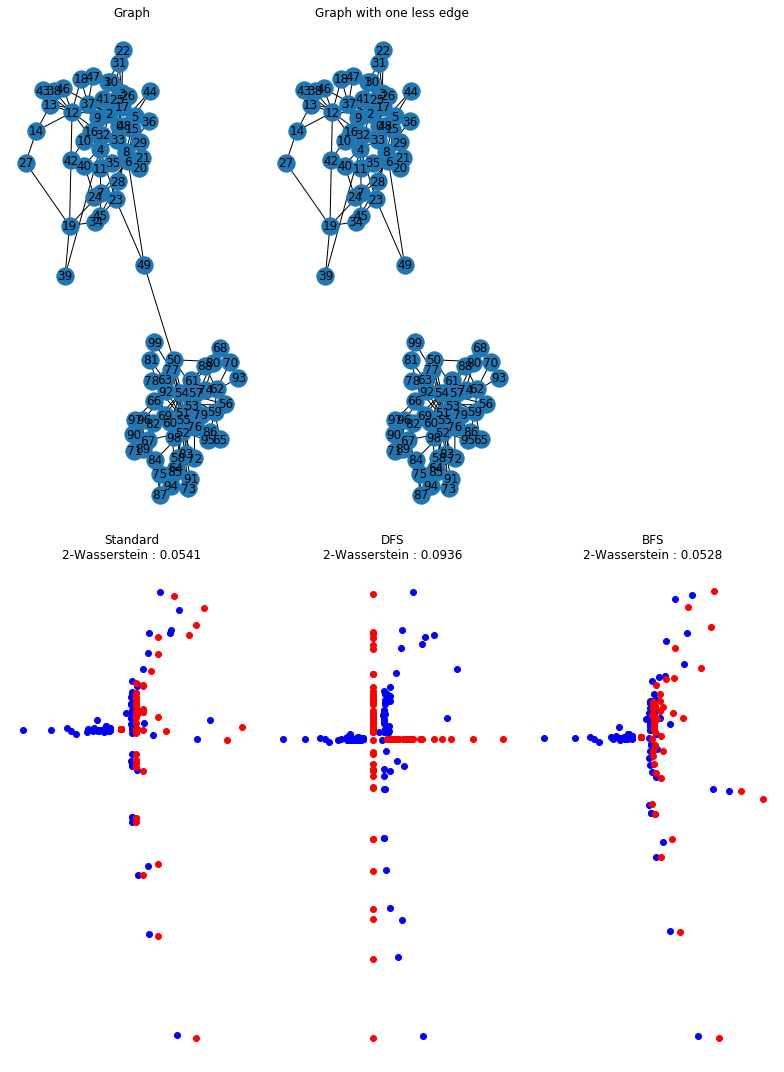

In [7]:
# plot the graph
fig, axes = plt.subplots(figsize=(11,15), nrows=2, ncols=3)

emb_std = emb_std[:, 1:]
emb_dfs = emb_dfs[:, 1:]
emb_bfs = emb_bfs[:, 1:]

emb_removed_std = emb_removed_std[:, 1:]
emb_removed_dfs = emb_removed_dfs[:, 1:]
emb_removed_bfs = emb_removed_bfs[:, 1:]

wass_std = wasserstein_metric(emb_std, emb_removed_std)
wass_dfs = wasserstein_metric(emb_dfs, emb_removed_dfs)
wass_bfs = wasserstein_metric(emb_bfs, emb_removed_bfs)

ax = axes[0, 0]
nx.draw_networkx(G, pos=pos, ax=ax)
ax.set_title('Graph')
ax.axis('off')

ax = axes[0, 1]
nx.draw_networkx(G_removed, pos=pos, ax=ax)
ax.set_title('Graph with one less edge')
ax.axis('off')

ax = axes[0, 2]
ax.axis('off')

ax = axes[1, 0]
ax.scatter(emb_std[:, 0], emb_std[:, 1], label='original', color='b')
ax.scatter(emb_removed_std[:, 0], emb_removed_std[:, 1], label='removed', color='r')
ax.set_title('Standard\n2-Wasserstein : {:.4f}'.format(wass_std))
# ax.legend()
ax.axis('off')

ax = axes[1, 1]
ax.scatter(emb_dfs[:, 0], emb_dfs[:, 1], label='original', color='b')
ax.scatter(emb_removed_dfs[:, 0], emb_removed_dfs[:, 1], label='removed', color='r')
ax.set_title('DFS\n2-Wasserstein : {:.4f}'.format(wass_dfs))
# ax.legend()
ax.axis('off')

ax = axes[1, 2]
ax.scatter(emb_bfs[:, 0], emb_bfs[:, 1], label='original', color='b')
ax.scatter(emb_removed_bfs[:, 0], emb_removed_bfs[:, 1], label='removed', color='r')
ax.set_title('BFS\n2-Wasserstein : {:.4f}'.format(wass_bfs))
# ax.legend()
ax.axis('off')

plt.tight_layout()
plt.show()

fig.savefig('rwf_bridge_removal.eps')